In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(threshold=np.inf)
from pathlib import Path
import os
import scipy.io as sio
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
from skimage import measure

# Functions

In [2]:
def plot_insole_grid(grid):
    fig = plt.figure(figsize = (8,4))
    plt.imshow(reshape_insole_grid(insoleAll_l[0]), cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Pixel intensity')
    plt.title('64x16 Array Pixel Representation')
    # plt.show()
    return fig

def reshape_insole_grid(data):
    data = data.reshape(16,64).T
    data[:32,] = np.flipud(data[:32,])
    return data

def filter_coordinates(grid, threshold = 0):
    return np.argwhere(grid > threshold)

In [34]:
def calculate_centroid(grid_data, region_threshold = 20):
    # Apply a Gaussian filter to smooth the data slightly
    smoothed_data = gaussian_filter(grid_data, sigma=1)
#     smoothed_data = grid_data
    
    # This threshold is set to detect significant pressure areas, typically in toes and heels
    threshold = np.mean(smoothed_data) + 0.5 * np.std(smoothed_data)
    binary_data = smoothed_data > threshold
    
    # Identify regions (blobs) in the binary data
    # Label the regions for boundary detection
    labels = measure.label(binary_data, connectivity=2)
    regions = measure.regionprops(labels)
    
    # Calculate the centroids for each labeled region (non-zero class)
    centroids = []
    
    for region in regions:
        # Ensure the region is significant in size
        if region.area >= region_threshold:
            centroids.append(region.centroid)
    
    # Plot the original data with detected boundaries overlayed
    fig, ax = plt.subplots()
    ax.imshow(grid_data, cmap='viridis')
    ax.set_title("Toes and Heels AOI", pad=20)
    
    # Draw boundaries around regions (toes and heels likely)
    for region in regions:
        # Exclude very small regions to focus on main areas
        if region.area >= region_threshold:  # Arbitrary minimum area threshold for significant region
            # Get boundary coordinates
            for coord in region.coords:
                ax.plot(coord[1], coord[0], marker="o", color="red", markersize=5, alpha = 0.3)
    
    # Draw red areas for centroids of each significant region
    for centroid in centroids:
        # Plot a small red area around the centroid position
        ax.add_patch(plt.Circle((centroid[1], centroid[0]), radius=1, color='yellow', alpha=1))
    
    plt.colorbar(ax.imshow(grid_data, cmap='viridis'), label="Pressure Intensity", pad=0.02)
    plt.xlabel("Width")
    plt.ylabel("Length")
    plt.tight_layout()
    # plt.show()

    return centroid, labels, fig, smoothed_data

# Load&Process Data

In [27]:
# date = '102324'
# walk_num = 3
# data = sio.loadmat(f'data/{date}/gait_recording_{date}_walk{walk_num}.mat')

ID = 'GAIT080624-01'
date = ID[4:10]
walk_num = 1
# data = sio.loadmat(f'data/{ID}/gait_recording_{date}_walk{walk_num}.mat')
data = sio.loadmat('./data/gait_recording_080624_walk2.mat')

insoleAll_l = data['insoleAll_l'].astype(np.float64)
insoleAll_r = data['insoleAll_r'].astype(np.float64)
t_insole_l = data['t_insole_l'].astype(np.float64)
t_insole_r = data['t_insole_r'].astype(np.float64)

In [28]:
insoleAll_l.shape

(9455, 1024)

# Stack Data

100%|██████████| 9455/9455 [00:00<00:00, 68983.82it/s]


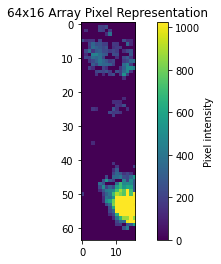

In [29]:
insole_data = insoleAll_l

# Create a zero array to stack the frames
stacked_grid_l = np.zeros((64,16))
for i in tqdm(range(insole_data.shape[0])):
    grid = reshape_insole_grid(insoleAll_l[i])
    stacked_grid_l += grid

fig = plot_insole_grid(stacked_grid_l)

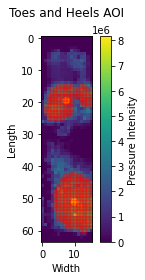

In [35]:
centroid, labels, fig, smoothed_data_l = calculate_centroid(stacked_grid_l)

100%|██████████| 9450/9450 [00:00<00:00, 66420.17it/s]


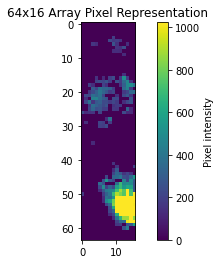

In [31]:
insole_data = insoleAll_r

# Create a zero array to stack the frames
stacked_grid_r = np.zeros((64,16))
for i in tqdm(range(insole_data.shape[0])):
    grid = reshape_insole_grid(insoleAll_r[i])
    grid = np.fliplr(grid)
    stacked_grid_r += grid

fig = plot_insole_grid(stacked_grid_r)

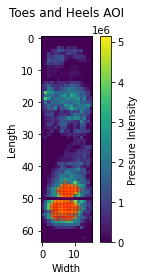

In [32]:
centroid, labels, fig, smoothed_data_r = calculate_centroid(stacked_grid_r)

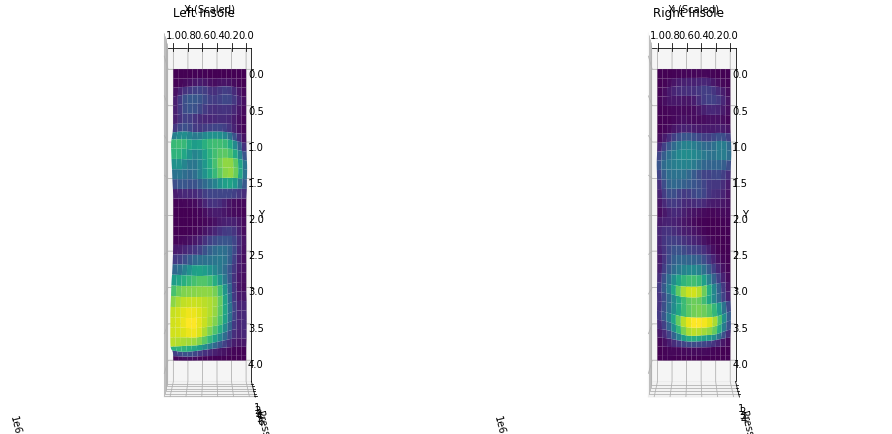

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Generate grid for X and Y, with non-square aspect ratio
x = np.linspace(0, 1, smoothed_data_l.shape[1])  # Stretch X-axis (aspect ratio 4:1)
y = np.linspace(0, 4, smoothed_data_l.shape[0])  # Keep Y-axis as is
X, Y = np.meshgrid(x, y)

# Plotting the heatmaps in 3D
fig = plt.figure(figsize=(14, 6))

# Left Insole 3D Plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, smoothed_data_l, cmap='viridis')
ax1.set_title("Left Insole")
ax1.set_xlabel('X (Scaled)')
ax1.set_ylabel('Y')
ax1.set_zlabel('Pressure')
ax1.view_init(90,90)
ax1.set_aspect('equalxy')


# Right Insole 3D Plot
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, smoothed_data_r, cmap='viridis')
ax2.set_title("Right Insole")
ax2.set_xlabel('X (Scaled)')
ax2.set_ylabel('Y')
ax2.set_zlabel('Pressure')
ax2.view_init(90,90)
ax2.set_aspect('equalxy')

plt.tight_layout()
plt.show()
